#Team DEAN:
#**D**avid Wei | **E**dward Roske | **A**dam Canton | **N**eil Benson
#**Team Goal**
*   **Problem**: Identifying (and hopefully using this information to reduce) hospital readmission of patients with Diabetes within 30 days.
*   **Description**: "We don't want people in hospitals. We want them to be well. And we certainly don't want them to be readmitted. This comes at a huge cost to the patient in terms of bills, lost wages, strain on their family amongst other negative outcomes. If enough people are readmitted in a short amount of time, it can stress the whole hospital system. So our goal is no readmission," per the client in the Async videos.
*   **Ethics**: While we considered eliminating data that might introduce sexism, ageism, or racism into the model, we decided to leave this data in. We are not making negative judgements based on gender, age, or race: we are using this data because it is a helpful predictor of readmittance (and of imputing missing values). In the end, *our goal is to reduce readmissions for all genders, for all ages, for all races*... and the best way to accomplish this is by using all available data.  
  
# **Data Issues and Adjustments**
*   **Missing Data**: There is no explicit missing data (all intersections of attributes and observations have *a value*), however, there are quite a few missing data markers. These missing data markers ('?') make up nearly 97% of the weight feature, for example. There are also several ID types that are either mapped to NaN or not mapped at all: 5.5% of Admission IDs, 4.6% of Discharge IDs, and 6.7% of Admission Source IDs.
*   **Data Adjustments**: 
  *  **Diag Codes**: 915 unique Diag(nostic) codes, split between diags_1-3. If all 3 codes were missing the row was dropped. Otherwise, the row entries were replaced with unknown. Further, we researched diagnostic codes, and we believe that the codes referred to the ICD-9 medical codes. This assumption allows us to represent these 915 codes as 17 unique categories.
  *  **Race/payer_code/medical_specialty**/: Missing values replaced with unknown.
  * **Discharge/Admission Description**: Have been dropped. These are not neccessary for modeling since we have the codes.
  *  **Weight**: The missing weights have been imputed using the mode for a given gender, age, and race. However, because of some missing race entries there are still some weights listed as unknown. This allowed us to have categories for all but 5% of weights (listed as unknown which is still a category) down from 97%.
  *  **Citoglobin**: Dropped due to being a singular feature, all entries were negative.
  *  **Readmission (Target)**: Originally the datset had a multiclass target, this has been changed to reflect the needs of the customer to a binary target. Class 0 - not readmitted within 30 days (either because they were not readmitted or were readmitted after 30 days), and Class 1 - readmitted within 30 days.
  * **Continous and Categorical**: Continuous variables have been standard scaled (for direct ease of comparison) and categoricals were one hot encoded (for use in logistic regression).
  * **Final Data**: 84,367 rows down from 101,766, a decrease of approximately 17% with 53 columns. We felt this was an acceptable loss of data, since significant recovery and cleaning efforts were made. We also have more than enough data for the central limit theorem to give us normal distributions across our attributes.

#**Modeling**: 
  *  **Models**: We ran 15 different individual models including random forests, logistic regressions, as well as various boosted methods. We also ran some ensemble methods in which multiple classifiers were grouped together and voted for the final classification. For a full listing of what models were run and a table of their results see [Model Run Results](#ModelRunResults).
  * **Model Metrics**: For this particular problem we rated the models on Accuracy, AUC, Precision, and Recall. However, we will chiefly talk about the results in terms of precision (a way to assess false positives, that is patients we predicted would be readmitted that were not) and recall (a way to assess false negatives, or patients we predicted would not be readmitted that were). Here it would seem that recall is the more important metric as false negatives would be far more detrimental to hospital operations. Since in this case if we took the predictions as truth, we would be underestimating the amount of people being readmitted. With this analysis, we should be able to intervene in time to prevent far more patients from being readmitted than if our analysis had not occurred.
  *  **Model Hyperparameters**: The hyperparameters were tuned only after we had selected a model by running a large slate of different models in order to see which ones held the most promise. It should be noted that all of our tuning and ensembling led to worse results than the intial run. So we kept the original, but the hospital can feel confident that we did try to improve performance even further.

#### **Conclusion**: Please see [Conclusion](#Conclusion).




# Packages

Disable output scrolling

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
# sys
import warnings
warnings.filterwarnings('ignore') #ignoring warnings

# SKLearn
import sklearn
from sklearn import datasets, tree, neighbors, decomposition, datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# Other Packages
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pandas as pd
#from pandas_profiling import ProfileReport
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

In [ ]:
# intel patch for running sklearn - this helps performance a lot
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Note that the ID mappings are actually 3 different tables; they are split out below

# EDA

## Data Profiling

Data Loading

In [ ]:
df1 = pd.read_csv("https://raw.githubusercontent.com/bensonnd/msds/master/ds7333/case_study_2/Data/IDs_mapping.csv")
df2 = pd.read_csv("https://raw.githubusercontent.com/bensonnd/msds/master/ds7333/case_study_2/Data/diabetic_data.csv")

Checking columns

In [ ]:
print(df1.columns)
print(df2.columns)
print(len(df2))

Index(['admission_type_id', 'description'], dtype='object')
Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')
101766


Taking a sneak peak at diabetes data set, showing all columns with `display.max_columns`:

In [ ]:
pd.set_option('display.max_columns', None)
df2.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Analyzing ID (Admission Type, Admission Source, Discharge Disposition) Codes

In this section we will be analyzing the secondary data file (ID_mappings.csv), which contains dictionary values of the ID attribute values and their descriptive values. To better analyze the data, we first split out each dictionary into its own groupings of Admission_Type, Admission_Source and Discharge Disposition. Once these dictionaries have been separated, we will clean them up by removing empty data and filtering out categories that do not provide value to our modeling.

In [ ]:
# Admission Type ID
admission_type_id = df1.iloc[0:9]

# removing the extra empty row
admission_type = admission_type_id[admission_type_id['admission_type_id'].notnull()].rename(columns={'description': 'admission_type_desc'})

#convert id to int
admission_type['admission_type_id'] = admission_type['admission_type_id'].astype(str).astype(int)
admission_type

,admission_type_id,admission_type_desc
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped


We observe that only 5.5% of total data has Admission_Type_ID values that are either not available (NaN) or Not Mapped. Due to the low percentage of these inoperative categories, we will remove them.

In [ ]:
total = len(df2)
#where the admission_type_id = [NaN, 'Not Mapped']
admission_type_remove = df2[(df2.admission_type_id == 6) | (df2.admission_type_id == 8)].shape[0]
admission_remove_perc = (admission_type_remove/total)*100
print(str(admission_remove_perc)+'%')

#remove where the admission_type_id = [NaN, 'Not Mapped']
admission_type_val = [6, 8]
admission_type = admission_type[~admission_type.admission_type_id.isin(admission_type_val)]
admission_type

5.513629306448126%


,admission_type_id,admission_type_desc
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
6,7,Trauma Center


# of Rows with [admission_type_id]=6: 5291


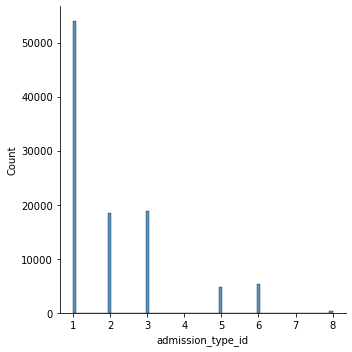

In [ ]:
print('# of Rows with [admission_type_id]=6: '+str(df2[df2.admission_type_id == 6].shape[0]))
sns.displot(df2, x="admission_type_id")

In [ ]:
# Discharge ID
discharge = df1.iloc[9:41]
discharge.columns = discharge.iloc[0]
discharge.drop(discharge.index[0], inplace=True)

# removing the extra empty row
discharge = discharge[discharge['discharge_disposition_id'].notnull()].rename(columns={'description': 'discharge_disposition_desc'})

# convert id to int
discharge['discharge_disposition_id'] = discharge['discharge_disposition_id'].astype(str).astype(int)
discharge

9,discharge_disposition_id,discharge_disposition_desc
10,1,Discharged to home
11,2,Discharged/transferred to another short term h...
12,3,Discharged/transferred to SNF
13,4,Discharged/transferred to ICF
14,5,Discharged/transferred to another type of inpa...
15,6,Discharged/transferred to home with home healt...
16,7,Left AMA
17,8,Discharged/transferred to home under care of H...
18,9,Admitted as an inpatient to this hospital
19,10,Neonate discharged to another hospital for neo...


We observe that only 4.59% of total data has discharge_disposition_id values that are either not available (NaN) or Not Mapped. Due to the low percentage of these inoperative categories, we will remove them.

In [ ]:
total = len(df2)

#where the discharge_disposition_id = [NaN, 'Not Mapped', 'Unknown/Invalid']
discharge_disposition_remove = df2[(df2.discharge_disposition_id == 18) | (df2.discharge_disposition_id == 25) | (df2.discharge_disposition_id == 26)].shape[0]
discharge_disposition_remove_perc = (discharge_disposition_remove/total)*100
print(str(discharge_disposition_remove_perc)+'%')

#remove where the discharge_disposition_id = [NaN, 'Not Mapped', 'Unknown/Invalid']
discharge_val = [18, 25, 26]
discharge = discharge[~discharge.discharge_disposition_id.isin(discharge_val)]
discharge


4.598785448971169%


9,discharge_disposition_id,discharge_disposition_desc
10,1,Discharged to home
11,2,Discharged/transferred to another short term h...
12,3,Discharged/transferred to SNF
13,4,Discharged/transferred to ICF
14,5,Discharged/transferred to another type of inpa...
15,6,Discharged/transferred to home with home healt...
16,7,Left AMA
17,8,Discharged/transferred to home under care of H...
18,9,Admitted as an inpatient to this hospital
19,10,Neonate discharged to another hospital for neo...


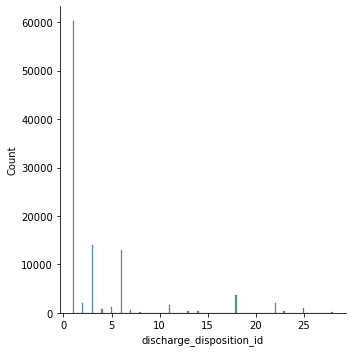

In [ ]:
#print('# of Rows with [admission_type_id]=6: '+str(discharge[discharge.discharge == 6].shape[0]))
sns.displot(df2, x="discharge_disposition_id")

In [ ]:
# Admission Source Code
admission_source = df1.iloc[41:67]
admission_source.columns = admission_source.iloc[0]
admission_source.drop(admission_source.index[0], inplace=True)
admission_source = admission_source.rename(columns={'description': 'admission_source_desc'})

#convert id to int
admission_source['admission_source_id'] = admission_source['admission_source_id'].astype(str).astype(int)
admission_source

41,admission_source_id,admission_source_desc
42,1,Physician Referral
43,2,Clinic Referral
44,3,HMO Referral
45,4,Transfer from a hospital
46,5,Transfer from a Skilled Nursing Facility (SNF)
47,6,Transfer from another health care facility
48,7,Emergency Room
49,8,Court/Law Enforcement
50,9,Not Available
51,10,Transfer from critial access hospital


We observe that only 6.66% of total data has admission_source_id values that are either not available (NaN) or Not Mapped. Due to the low percentage of these inoperative categories, we will remove them.

In [ ]:
total = len(df2)
#where the discharge_disposition_id = [NaN, 'Not Mapped', 'Unknown/Invalid']
admission_source_remove = df2[(df2.admission_source_id == 17) | (df2.discharge_disposition_id == 20) | (df2.discharge_disposition_id == 21)].shape[0]
admission_source_remove_perc = (admission_source_remove/total)*100
print(str(admission_source_remove_perc)+'%')

#remove where the discharge_disposition_id = [NaN, 'Not Mapped', 'Unknown/Invalid']
admission_source_val = [17, 20, 21]
admission_source = admission_source[~admission_source.admission_source_id.isin(admission_source_val)]
admission_source

6.664308315154374%


41,admission_source_id,admission_source_desc
42,1,Physician Referral
43,2,Clinic Referral
44,3,HMO Referral
45,4,Transfer from a hospital
46,5,Transfer from a Skilled Nursing Facility (SNF)
47,6,Transfer from another health care facility
48,7,Emergency Room
49,8,Court/Law Enforcement
50,9,Not Available
51,10,Transfer from critial access hospital


### Observing Attribute Unique Values
There are a lot of unique diagnosis codes in this data set, which will contribute to a large number of attributes once these are one-hot-encoded. We distill these down to more manageable categorical groups later. 

In [ ]:
# diagnosis codes
diags = ['diag_1', 'diag_2', 'diag_3']

unique_diags_set = {diag for sublist in [df2[i].unique() for i in diags] for diag in sublist if diag != '?'}

print(f"{len(unique_diags_set)} known unique diagnoses between `diag_1`, `diag_2`, and `diag_3`.")

# source:
# adapted from https://www.geeksforgeeks.org/nested-list-comprehensions-in-python/

915 known unique diagnoses between `diag_1`, `diag_2`, and `diag_3`.


### Testing for Duplicate Columns

Test if there are any duplicate columns:

In [ ]:
print(df1.columns.duplicated())
print('='*80)
print(df2.columns.duplicated())

[False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]


Test if the primary key 'encounter_id' is unique

*   List item
*   List item



In [ ]:
pd.Series(df2['encounter_id']).is_unique

True

## Data Tidying

Remove spaces in columns name:

In [ ]:
df2.columns = df2.columns.str.strip()

Convert ids to ints:

In [ ]:
df_ids = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
for i in df_ids:
  df2[i] = df2[i].astype(str).astype(int)

### Joining IDs to Diabetes Data Set

After analyzing and cleaning up the the ID (Admission Type, Admission Source, Discharge Disposition) dictionaries, we inner join the remaining categories back to our main diabetes dataset.  

In [ ]:
# inner join cleaned up IDs to diabetes dataset
df = pd.merge(df2, admission_type, how='inner', on=['admission_type_id']).merge(discharge, how='inner', on=['discharge_disposition_id']).merge(admission_source, how='inner', on=['admission_source_id'])

# checking the ID mapping after the join
df[['admission_type_id', 'admission_type_desc', 'discharge_disposition_id', 'discharge_disposition_desc', 'admission_source_id', 'admission_source_desc']].head(5)

,admission_type_id,admission_type_desc,discharge_disposition_id,discharge_disposition_desc,admission_source_id,admission_source_desc
0,1,Emergency,1,Discharged to home,7,Emergency Room
1,1,Emergency,1,Discharged to home,7,Emergency Room
2,1,Emergency,1,Discharged to home,7,Emergency Room
3,1,Emergency,1,Discharged to home,7,Emergency Room
4,1,Emergency,1,Discharged to home,7,Emergency Room


In [ ]:
# quick sanity check
df.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_disposition_desc,admission_source_desc
0,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
1,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room
2,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
3,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
4,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,?,?,73,0,12,0,0,0,428,492,250,8,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,>30,Emergency,Discharged to home,Emergency Room


### Missing Values
Missing values are presented as `'?'` and thus get counted as a string; convert to np.nan in order to count missing values.

In [ ]:
# converting '?' to missing values
df.replace({'?': np.nan}, inplace=True)

In [ ]:
# checking for missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88472 entries, 0 to 88471
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   encounter_id                88472 non-null  int64 
 1   patient_nbr                 88472 non-null  int64 
 2   race                        86337 non-null  object
 3   gender                      88472 non-null  object
 4   age                         88472 non-null  object
 5   weight                      2669 non-null   object
 6   admission_type_id           88472 non-null  int32 
 7   discharge_disposition_id    88472 non-null  int32 
 8   admission_source_id         88472 non-null  int32 
 9   time_in_hospital            88472 non-null  int64 
 10  payer_code                  59751 non-null  object
 11  medical_specialty           44526 non-null  object
 12  num_lab_procedures          88472 non-null  int64 
 13  num_procedures              88472 non-null  in

Here are our attributes with missing data:

In [ ]:
# list columns with missing data
missing_data = list(df.columns[df.isnull().any()])
missing_data

['race',
 'weight',
 'payer_code',
 'medical_specialty',
 'diag_1',
 'diag_2',
 'diag_3']

To handle missing data we will take several different approaches:
* For `diag_1`, `diag_2`, and `diag_3`, we will drop any rows where all 3 are missing and then flag any missing values as `unknown`.
* For `race`, `payer_code`, `medical_specialty`, we will flag missing data as `unknown`.
* For `weight`, we will impute the mode based on `gender`, `age`, and `race`.


Drop rows with no diagnoses in all of `diag_1`, `diag_2`, and `diag_3`:

In [ ]:
cols = df.loc[:0, 'diag_1':'diag_3'].columns  # retrieve only the 0th row for efficiency
df = df.dropna(subset=cols, how='all')

# source:
# adapted from https://stackoverflow.com/questions/46864740/selecting-a-subset-using-dropna-to-select-multiple-columns

Flagging missing values for `diag_1`,`diag_2`,`diag_3`, `race`, `payer_code`, and `medical_specialty` with `unknown`:

In [ ]:
# flagging missing values for categorical attributes to 'Unknown'
cat_cols = ['diag_1', 'diag_2', 'diag_3','race','payer_code','medical_specialty']
df[cat_cols] = df[cat_cols].replace({np.nan:'Unknown'})

# source:
# adapted from https://stackoverflow.com/questions/45416684/python-pandas-replace-multiple-columns-zero-to-nan                                  

Function that imputes mode or median depending on data type for all other missing data:

In [ ]:
impute = lambda x: x.median() if np.issubdtype(x.dtype, np.number) else next(iter(x.mode()), np.nan)

# source
# adapted from https://stackoverflow.com/questions/59127458/pandas-fillna-using-groupby-and-mode

Imputing missing values by `age`, `gender`, and `race` groups. 
Note: only `weight` column still has missing data at this point.

In [ ]:
print(f"Weight count, not including missing: {df['weight'].notnull().sum()}")

Weight count, not including missing: 2669


In [ ]:
# using the impute function to fillna based on group
df = df.fillna(df.groupby(['age','gender', 'race']).transform(impute))

In [ ]:
print(f"Weight count, after mode imputation: {df['weight'].notnull().sum()}\n"
     f"Weight count of missing still: {df.shape[0] - df['weight'].notnull().sum()}")

Weight count, after mode imputation: 84367
Weight count of missing still: 4104


Not all weight rows were imputed (gender, age, race might be missing), flagging the remaining missing values for `weight` to `Unknown`.

In [ ]:
cat_cols = ['weight']
df[cat_cols] = df[cat_cols].replace({np.nan:'Unknown'})

# source:
# adapted from https://stackoverflow.com/questions/45416684/python-pandas-replace-multiple-columns-zero-to-nan 

After imputation, the total number of records containing missing data:

In [ ]:
missing = df.isnull().any(axis=1).sum()
len_before = df.shape[0]
print(f"Total records missing data: {missing}\n"
      f"Total percent of incomplete records: {missing/len_before*100:.2f}%"
     )

Total records missing data: 0
Total percent of incomplete records: 0.00%


### Check for full row duplicates

In [ ]:
dups = df.loc[:, df.columns != 'encounter_id'].duplicated().sum()

f"{dups/len(df)*100:1.2f}% of all records are considered duplicates"

# source:
# adapted from: https://stackoverflow.com/questions/35584085/how-to-count-duplicate-rows-in-pandas-dataframe

'0.00% of all records are considered duplicates'

### Setting appropriate datatypes

In [ ]:
# need to change these IDs to objects
df['admission_type_id'] = df['admission_type_id'].astype('object')
df['admission_source_id'] = df['admission_source_id'].astype('object')
df['discharge_disposition_id'] = df['discharge_disposition_id'].astype('object')

### Dropping redundant columns
`admission_type_desc`, `discharge_disposition_desc`, and `admission_source_desc` are represented by their respective ID's. Dropping the descriptions of these.

`citoglipton` is singular, all values `no`. Because this doesn't help predict anything or provide any value, we will also drop this column.

In [ ]:
df = df.drop(['admission_type_desc','discharge_disposition_desc','admission_source_desc','citoglipton'], axis=1)

#### Checking for multicollinearity within the numerical columns

Applying a correlation heatmap to our set of continuous attributes to test for potential multicollinearity, we found that there was only modest correlation among the attributes with the highest correlation of .49 between [**patient_nbr**, **encounter_id**] and the second highest correlation of .47 between [**num_medications**, **time_in_hospital**]. We observed that all other attribute correlations were of weak correlation (corr < 0.4). Since none of the correlations were strong (> .5), we choose to leave all attributes in the model given the weak evidence of multicollinearity.  

In [ ]:
df_continous = df.loc[:, df.dtypes != object]

Wall time: 266 ms


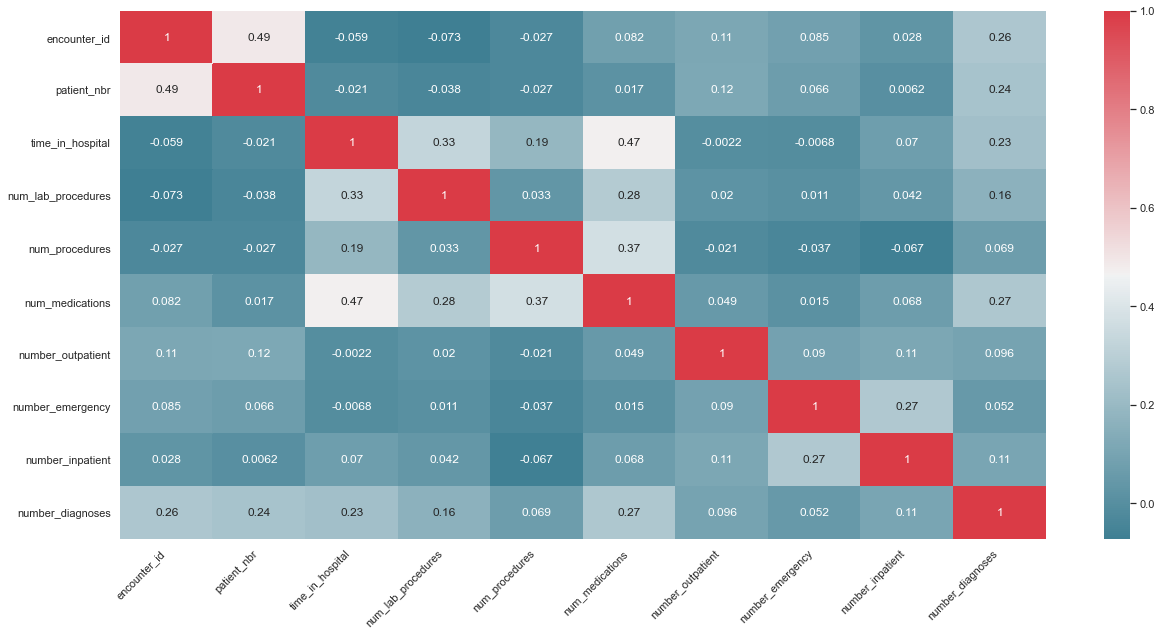

In [ ]:
%%time
#Correlation check
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

# show the heatmap
sns.set(style="darkgrid") # one of the many styles to plot using
f, ax = plt.subplots(figsize=(18, 9))
chart=sns.heatmap(df_continous.corr(), cmap=cmap, annot=True)
chart.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
f.tight_layout()

### Grouping diagnosis data into smaller categories
Grouping based on ICD-9 diagnosis codes found here:  
https://icd.codes/icd9cm

In [ ]:
# separating out the string values from the numeric in diagnoses fields
# adding a bunch of temp columns
    
# diag_1
df['diag_1_e'] = np.where(df['diag_1'].str.contains('E'), df['diag_1'], np.nan)
df['diag_1_v'] = np.where(df['diag_1'].str.contains('V'), df['diag_1'], np.nan)
df['diag_1_unknown'] = np.where(df['diag_1'].str.contains('Unknown'), df['diag_1'], np.nan)
df['diag_1_num'] = np.where(
    df['diag_1_e'].isnull() & df['diag_1_v'].isnull() & df['diag_1_unknown'].isnull(),
    df['diag_1'],
    np.nan
)



# diag_2
df['diag_2_e'] = np.where(df['diag_2'].str.contains('E'), df['diag_2'], np.nan)
df['diag_2_v'] = np.where(df['diag_2'].str.contains('V'), df['diag_2'], np.nan)
df['diag_2_unknown'] = np.where(df['diag_2'].str.contains('Unknown'), df['diag_2'], np.nan)
df['diag_2_num'] = np.where(
    df['diag_2_e'].isnull() & df['diag_2_v'].isnull() & df['diag_2_unknown'].isnull(),
    df['diag_2'],
    np.nan
)


# diag_1
df['diag_3_e'] = np.where(df['diag_3'].str.contains('E'), df['diag_3'], np.nan)
df['diag_3_v'] = np.where(df['diag_3'].str.contains('V'), df['diag_3'], np.nan)
df['diag_3_unknown'] = np.where(df['diag_3'].str.contains('Unknown'), df['diag_3'], np.nan)
df['diag_3_num'] = np.where(
    df['diag_3_e'].isnull() & df['diag_3_v'].isnull() & df['diag_3_unknown'].isnull(),
    df['diag_3'],
    np.nan
)

In [ ]:
# categorize 'e' based strings
for col in ['diag_1_e', 'diag_2_e', 'diag_3_e']:
    df.loc[df[col].notnull(), col] = 'E000-E999'
    
# categorize 'v' based strings 
for col in ['diag_1_v', 'diag_2_v', 'diag_3_v']:
    df.loc[df[col].notnull(), col] = 'V01-V91'

In [ ]:
# convert the numerical representations to numeric 
df[['diag_1_num','diag_2_num','diag_3_num']] = df[['diag_1_num','diag_2_num','diag_3_num']].apply(pd.to_numeric)

In [ ]:
# binning the numerical ranges for ICD9
bins = [0,139,239,279,289,319,
        389,459,519,579,629,679,
        709,739,759,779,799,1000]


labels =['000-139','140-239','240-279','280-289','290-319','320-389',
         '390-459','460-519','520-579','580-629','630-679','680-709',
         '710-739','740-759','760-779','780-799','800-999']


for col in ['diag_1_num', 'diag_2_num', 'diag_3_num']:
    df[col] = pd.cut(df[col], bins,labels=labels)    

In [ ]:
# function to coalesce across columns
def coalesce(dfrow, columns_to_search):
    for c in columns_to_search:
        if pd.notnull(dfrow[c]):
            return dfrow[c]
    return None

In [ ]:
# coalescing all the diagnosis columns together
diag_1_cols = ['diag_1_e', 'diag_1_v', 'diag_1_unknown', 'diag_1_num']
df['diag_1_coalesce'] = df.apply(lambda x: coalesce(x, diag_1_cols), axis=1)

diag_2_cols = ['diag_2_e', 'diag_2_v', 'diag_2_unknown', 'diag_2_num']
df['diag_2_coalesce'] = df.apply(lambda x: coalesce(x, diag_2_cols), axis=1)

diag_3_cols = ['diag_3_e', 'diag_3_v', 'diag_3_unknown', 'diag_3_num']
df['diag_3_coalesce'] = df.apply(lambda x: coalesce(x, diag_3_cols), axis=1)

In [ ]:
# dropping unneeded temp columns and renaming diagnoses columns
cols_to_drop = ['diag_1','diag_1_e', 'diag_1_v', 'diag_1_unknown', 'diag_1_num',
                'diag_2','diag_2_e', 'diag_2_v', 'diag_2_unknown', 'diag_2_num',
                'diag_3','diag_3_e', 'diag_3_v', 'diag_3_unknown', 'diag_3_num']

df = df.drop(cols_to_drop, axis=1)

# renaming the new columns
df.rename(columns = {'diag_1_coalesce':'diag_1', 
                     'diag_2_coalesce':'diag_2', 
                     'diag_3_coalesce':'diag_3'}, inplace = True)

In [ ]:
# reording the columns
df = df[[
'encounter_id', 'admission_type_id', 'discharge_disposition_id', 
'admission_source_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 
'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 
'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 
'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 
'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 
'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 
'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 
'troglitazone', 'tolazamide', 'examide', 'insulin', 'glyburide-metformin', 
'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'
]]

### Setting the target and the attribute data

In [ ]:
# attributes/predictor variables
X = df.loc[:, df.columns != 'readmitted']

# target
y = df['readmitted']

### Prepare target variable
Converting the target to binary.  
Note: readmission > 30 is set to no, < 30 to yes.

In [ ]:
y = y.replace({'>30':'NO'})
y = y.replace({'<30':'YES'})

y = y.replace({'NO':'0'})
y = y.replace({'YES':'1'})

### One Hot Encoding Categorical Variables

In [ ]:
X_ohe = pd.get_dummies(X, drop_first=True)

In [ ]:
X_ohe.head()

,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_7,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,discharge_disposition_id_11,discharge_disposition_id_12,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_15,discharge_disposition_id_19,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_27,discharge_disposition_id_28,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_22,admission_source_id_25,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,gender_Male,gender_Unknown/Invalid,age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),weight_Unknown,weight_[0-25),weight_[100-125),weight_[125-150),weight_[150-175),weight_[175-200),weight_[25-50),weight_[50-75),weight_[75-100),payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_FR,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_Unknown,payer_code_WC,medical_specialty_Anesthesiology,medical_specialty_Anesthesiology-Pediatric,medical_specialty_Cardiology,medical_specialty_Cardiology-Pediatric,medical_specialty_DCPTEAM,medical_specialty_Dentistry,medical_specialty_Dermatology,medical_specialty_Emergency/Trauma,medical_specialty_Endocrinology,medical_specialty_Endocrinology-Metabolism,medical_specialty_Family/GeneralPractice,medical_specialty_Gastroenterology,medical_specialty_Gynecology,medical_specialty_Hematology,medical_specialty_Hematology/Oncology,medical_specialty_Hospitalist,medical_specialty_InfectiousDiseases,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Neurology,medical_specialty_Neurophysiology,medical_specialty_Obsterics&Gynecology-GynecologicOnco,medical_specialty_Obstetrics,medical_specialty_ObstetricsandGynecology,medical_specialty_Oncology,medical_specialty_Ophthalmology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Osteopath,medical_specialty_Otolaryngology,medical_specialty_OutreachServices,medical_specialty_Pathology,medical_specialty_Pediatrics,medical_specialty_Pediatrics-AllergyandImmunology,medical_specialty_Pediatrics-CriticalCare,medical_specialty_Pediatrics-EmergencyMedicine,medical_specialty_Pediatrics-Endocrinology,medical_specialty_Pediatrics-Hematology-Oncology,medical_specialty_Pediatrics-InfectiousDiseases,medical_specialty_Pediatrics-Neurology,medical_specialty_Pediatrics-Pulmonology,medical_specialty_Perinatology,medical_specialty_PhysicalMedicineandRehabilitation,medical_specialty_PhysicianNotFound,medical_specialty_Podiatry,medical_specialty_Proctology,medical_specialty_Psychiatry,medical_specialty_Psychiatry-Addictive,medical_specialty_Psychiatry-Child/Adolescent,medical_specialty_Psychology,medical_specialty_Pulmonology,medical_specialty_Radiologist,medical_specialty_Radiology,medical_specialty_Resident,medical_specialty_Rheumatology,medical_specialty_SportsMedicine,medical_specialty_Surgeon,medical_specialty_Surgery-Cardiovascular,medical_specialty_Surgery-Cardiovascular/Thoracic,medical_specialty_Surgery-Colon&Rectal,medical_specialty_Surgery-General,medical_specialty_Surgery-Maxillofacial,medical_specialty_Surgery-Neuro,medical_specialty_Surgery-Pediatric,medical_specialty_Surgery-Plastic,me

In [ ]:
type(X_ohe)

pandas.core.frame.DataFrame

### Scaling/normalizing the data

In [ ]:
from sklearn.preprocessing import StandardScaler
# Once run, it will use scaled data for the remainder
# To run on unscaled data, do not run this cell
# scl = StandardScaler()
# scl.fit(X_ohe)
# X_ohe = scl.transform(X_ohe)

# Crossfold Setup

### Visualizing Response Variable Balance

0    78625
1     9846
Name: readmitted, dtype: int64


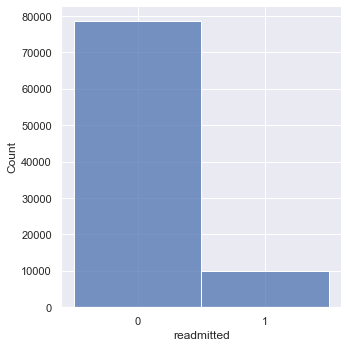

In [ ]:
sns.displot(y)
print(y.value_counts())

Because the target data is imbalanced, we want to stratify our folds. Setting up stratified 5 fold cv object.

In [ ]:
%%time
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

# define oversampling strategy
#undersample = RandomUnderSampler(sampling_strategy='majority')
undersample = NearMiss(version=3, n_neighbors_ver3=3)

# fit and apply the transform
X_undersample, y_undersample= undersample.fit_resample(X_ohe, y)

Wall time: 2.28 s


1    9846
0    9846
Name: readmitted, dtype: int64


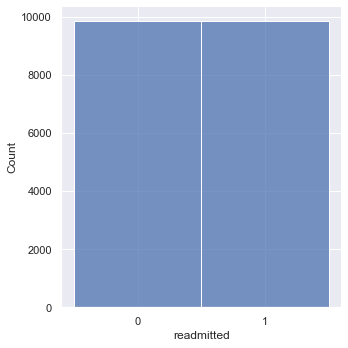

In [ ]:
sns.displot(y_undersample)
print(y_undersample.value_counts())

In [ ]:
type(X_ohe)

pandas.core.frame.DataFrame

In [ ]:
from sklearn.model_selection import StratifiedKFold

# setting up a cv object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)

for train, test in cv.split(X_ohe, y):
  X_train = X_ohe.iloc[train].values
  X_test = X_ohe.iloc[test].values
  y_train = y.iloc[train].values
  y_test = y.iloc[test].values

for train_undersample, test_undersample in cv.split(X_undersample, y_undersample):
  X_train_undersample = X_undersample.iloc[train_undersample].values
  X_test_undersample = X_undersample.iloc[test_undersample].values
  y_train_undersample = y_undersample.iloc[train_undersample].values
  y_test_undersample = y_undersample.iloc[test_undersample].values

# Modeling

## Initial Classification using Logistic Regression

We first begin our modeling process by applying a simple Logistic Regression model to measure baseline performance. The purpose of this will be to use Logistic Regression as not only a "standard" to which we will evaluate other competing models, but also to see how a manually-built model compares with a custom-tuned PyCaret model. To accomplish this, we will use two different datasets; one of which contains all data and the other a subset that addresses class imbalance of our response variable.

In [ ]:
from sklearn.linear_model import LogisticRegression

LR_clf = LogisticRegression(random_state = 0).fit(X_train, y_train)
LR_clf_undersample = LogisticRegression(random_state = 0).fit(X_train, y_train)

When measuring the accuracy of our initial Logistic Regression model, we can observe how an extremely high accuracy (0.88) is returned. However, when re-running the same model on an undersampled dataset that resolves the class imbalance, the overall accuracy drastically decreases by nearly 43%! This discrepancy in accuracy differences is demonstrated in the classification report where the non-undersampled model had no values classified as "1" given the absent Precision, Recall, and F1-score.

In [ ]:
LR_score = LR_clf.score(X_test, y_test)
LR_score_undersample = LR_clf_undersample.score(X_test_undersample, y_test_undersample)
print("Logistic Regression Accuracy:", LR_score)
print("Logistic Regression Accuracy (Undersampled):", LR_score_undersample)

Logistic Regression Accuracy: 0.888719339889228
Logistic Regression Accuracy (Undersampled): 0.5


In [ ]:
y_pred = LR_clf.predict(X_test)
y_pred_undersample = LR_clf.predict(X_test_undersample)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
print('='*80)
print(classification_report(y_test_undersample, y_pred_undersample))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     15725
           1       0.00      0.00      0.00      1969

    accuracy                           0.89     17694
   macro avg       0.44      0.50      0.47     17694
weighted avg       0.79      0.89      0.84     17694



## Modeling using PyCaret

In [ ]:
#!pip install pycaret[full] --user

##### NOTE: you may need to downgrade your scikit-learn package to version 0.23.2 to run the package successfully
##### Source: https://www.gitmemory.com/issue/pycaret/pycaret/1204/829269499

In [ ]:
#### TESTING PURPOSES ONLY
# work with 60% of data to test modeling
df_sample = df.sample(frac=0.60, replace=True, random_state=1)
print(len(df))
print(len(df_sample))

88471
53083


The following section sets up the PyCaret environment and imports the Classification module specifically. We will use our pre-processed and cleaned data (df) as our dataset and also allow PyCaret to run feature select for us. 

In [ ]:
%%time
from pycaret import classification
from pycaret.classification import compare_models

# supress INFO logs
import logging
logging.disable(logging.CRITICAL)

# # setting up the env on sample data
# classification_setup = classification.setup(data= df_sample, target='readmitted', 
#                                             imputation_type='iterative', silent=True,verbose=False)

# setting up the env on entire data
classification_setup = classification.setup(data= df, target='readmitted', 
                                            imputation_type='iterative', silent=True,verbose=False)

Wall time: 7.83 s


<a name="ModelRunResults"></a>
# Model Run Results


As you can see from the **Model Comparison Table** below, Random Forest Classifier outperformed every other model type (tested by PyCaret) including Logistic Regression. While our four measures we mentioned at the beginning were accuracy, AUC, precision, and recall (with an emphasis on the latter), the Random Forest model also ran quickly.

In [ ]:
#### ONE-TIME RUN (this takes a long time due to the number of models being run)
%%time
# report models
pycaret_classification_models = compare_models()
pycaret_classification_models

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7212,0.8469,0.5987,0.7410,0.7044,0.4737,0.4901,2.2360
et,Extra Trees Classifier,0.7158,0.8462,0.5971,0.7315,0.7000,0.4655,0.4799,2.7910
dt,Decision Tree Classifier,0.6525,0.7009,0.5889,0.6534,0.6529,0.3959,0.3960,0.2780
catboost,CatBoost Classifier,0.6466,0.7616,0.4847,0.6405,0.6151,0.3302,0.3405,4.3210
xgboost,Extreme Gradient Boosting,0.6464,0.7598,0.4919,0.6402,0.6186,0.3335,0.3424,8.6500
lightgbm,Light Gradient Boosting Machine,0.6357,0.7504,0.4725,0.6316,0.6027,0.3081,0.3183,0.3480
gbc,Gradient Boosting Classifier,0.6138,0.7190,0.4414,0.6071,0.5717,0.2526,0.2675,6.4130
ada,Ada Boost Classifier,0.6004,0.6956,0.4264,0.5649,0.5561,0.2243,0.2392,0.5490
lda,Linear Discriminant Analysis,0.5973,0.6953,0.4434,0.5666,0.5643,0.2319,0.2433,1.1770
ridge,Ridge Classifier,0.5972,0.0000,0.4202,0.5642,0.5496,0.2141,0.2299,0.0880


Wall time: 5min 26s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', maxBins=256, max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       max_samples=None, minBinSize=1,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=6064, verbose=0,
                       warm_start=False)

#### Building Models using top 3 comparison models

In [ ]:
%%time
# Random Forest Model
rf = classification.create_model('rf', verbose=False)

# Extra Trees Classifier
et = classification.create_model('et', verbose=False)

# Decision Tree Classifier
dt = classification.create_model('dt', verbose=False)

### The following models tend to bug out:
# # CatBoost Classifier
# catboost = classification.create_model('catboost', verbose=False)

# # # Extreme Gradient Boosting
# # xgboost = classification.create_model('xgboost', verbose=False)

Wall time: 2min 9s


#### Creating a Blended Model
A blended model is method of ensembling which uses consensus among estimators to generate final predictions. The idea behind blending is to combine different machine learning algorithms and use a majority vote or the average predicted probabilities in case of classification to predict the final outcome.

The 'soft' method uses predicted probabilities for voting and the 'hard' method uses predicted labels. 

We found that comparing a blended ensemble of our top 3 models: Random Forest Model, Extra Trees Classifier and Decision Tree Classifier, a 'hard' classification method resulted in a **mean recall of .5999** which was a higher recall than any of the individual models listed above. However, the precision is lower than Random Forest Classifier by itself.

Source: https://pycaret.org/blend-models/

In [ ]:
%%time
blended_soft = classification.blend_models(estimator_list = [rf,et,dt], method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6588,0.8333,0.5832,0.6550,0.6566,0.4003,0.4005
1,0.6668,0.8351,0.5899,0.6611,0.6633,0.4104,0.4110
2,0.6585,0.8311,0.5717,0.6514,0.6541,0.3939,0.3945
3,0.6620,0.8408,0.5985,0.6581,0.6596,0.4053,0.4057
4,0.6776,0.8511,0.6021,0.6740,0.6755,0.4334,0.4335
5,0.6666,0.8354,0.5810,0.6599,0.6625,0.4091,0.4097
6,0.6803,0.8509,0.5995,0.6736,0.6758,0.4317,0.4326
7,0.6792,0.8476,0.6072,0.6756,0.6772,0.4360,0.4361
8,0.6627,0.8329,0.5881,0.6589,0.6605,0.4067,0.4069
9,0.6735,0.8414,0.5965,0.6677,0.6698,0.4226,0.4233


Wall time: 1min 9s


In [ ]:
%%time
blended_hard = classification.blend_models(estimator_list = [rf,et,dt], method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7158,0.0000,0.5993,0.7148,0.7009,0.4716,0.4833
1,0.7118,0.0000,0.5941,0.7133,0.6957,0.4620,0.4749
2,0.7123,0.0000,0.5919,0.7123,0.6956,0.4619,0.4764
3,0.7260,0.0000,0.6145,0.7264,0.7123,0.4911,0.5033
4,0.7226,0.0000,0.6059,0.7206,0.7084,0.4853,0.4961
5,0.7121,0.0000,0.5903,0.7119,0.6959,0.4624,0.4752
6,0.7207,0.0000,0.6020,0.7253,0.7042,0.4766,0.4920
7,0.7191,0.0000,0.6052,0.7206,0.7051,0.4781,0.4887
8,0.7050,0.0000,0.5883,0.7072,0.6891,0.4483,0.4620
9,0.7211,0.0000,0.6076,0.7224,0.7065,0.4808,0.4935


Wall time: 1min 7s


#### Model Interpretation

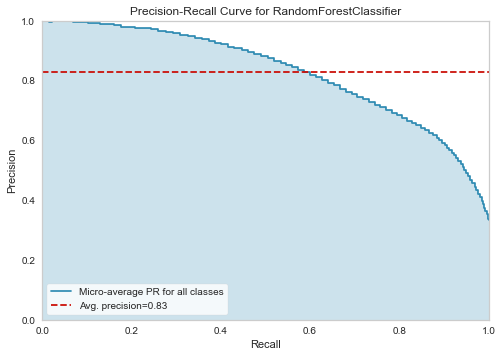

In [ ]:
classification.plot_model(rf, plot = 'pr')

#### Running Random Forest using custom tuning parameters

The PyCaret create_model by default uses 100 estimators, and a max_depth of None so essentially allowing nodes to expand until all leaves are pure or contain less than min_samples. This is very slow, prone to overfitting, and for interpretation purposes, perhaps not even necessary. Thus we will adjust the parameters to use less memory and improve overall performance by limiting the depth of each tree node to a maximum of 10. However, after adjusting for max_depth, we found that the mean recall & accuracy decreased by a modest amount (~20%). Thus we found that while the number of estimators remained the same, the competitive edge of the random forest model was it's ability to explore greater depths in each node and by limiting those depths, consequently resulted in lower recalls and accuracies as well.

Source: https://mljar.com/blog/random-forest-memory/

In [ ]:
%%time
# RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
#                         criterion='gini', maxBins=256, max_depth=None,
#                         max_features='auto', max_leaf_nodes=None,
#                         max_samples=None, minBinSize=1,
#                         min_impurity_decrease=0.0, min_impurity_split=None,
#                         min_samples_leaf=1, min_samples_split=2,
#                         min_weight_fraction_leaf=0.0, n_estimators=100,
#                         n_jobs=-1, oob_score=False, random_state=191, verbose=0,
#                         warm_start=False)
params = {"max_depth": [10]}

tuned_rf_custom = classification.tune_model(rf, custom_grid = params)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5811,0.6584,0.3873,0.5073,0.5043,0.1455,0.1833
1,0.5803,0.6516,0.3854,0.5070,0.5005,0.1410,0.1812
2,0.5871,0.6562,0.3930,0.5139,0.5127,0.1601,0.1985
3,0.5837,0.6644,0.3888,0.5119,0.5059,0.1494,0.1900
4,0.5900,0.6637,0.3942,0.5177,0.5138,0.1643,0.2060
5,0.5891,0.6664,0.3942,0.5187,0.5141,0.1627,0.2035
6,0.5902,0.6616,0.3955,0.5194,0.5161,0.1660,0.2063
7,0.5894,0.6743,0.3933,0.5220,0.5121,0.1605,0.2048
8,0.5861,0.6610,0.3908,0.5115,0.5089,0.1560,0.1961
9,0.5846,0.6552,0.3878,0.5112,0.5035,0.1486,0.1921


Wall time: 17.6 s


For intervention purposes, here are the attributes (in order) that were most associated with a change in readmission status:

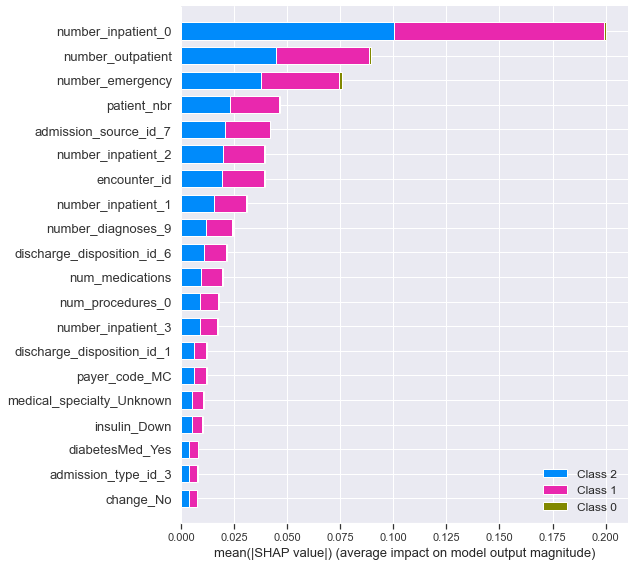

In [ ]:
%%time
classification.interpret_model(tuned_rf_custom)

<a name="Conclusion"></a>
# Conclusion

**"Winning" Model**: Random Forest Classifier
*   **Recall**: 0.5993 -  This indicates that we are predicting readmissions correctly about 60% of the time. Our false negative rate - patients we predicted would not be readmitted but were - is higher than we would like it to be, but this is an improvement over the trivial rate (discussed below) and definitely better than random chance.
*   **Precision**: 0.7435 - This indicates that of those that are actually readmitted we predicted about 74% correctly. This indicates our false positive rate is much lower than our false negatives. 

**Why Not Logistic Regression?:** Though the original request was simply for a logistic regression model, we did evaluate it as our initial model, and it performed quite poorly. The recall of the LR model was a bit more than half of our Random Forest model at 0.3475 (vs 0.5993). This large difference makes us comfortable that the increase in accurately identifying readmitted patients makes up for the change in model structure.  
  
**Conclusion**: The trivial prediction rate here is about 12.5% That is if we predicted every patient would be readmitted we would be correct about 12.5% of the time. Or to put it differently, we would be spending money on interventions 87.5% of the time when no actual intervention was required. In this sense our model does quite a bit better: when we predict a patient will be readmitted we are right about 60% time; a prediction rate nearly 5x better than the trivial rate. This can be extremely useful in medical interventions (to reduce the amount of readmissions, if possible) and in predicting hospital loads (to adjust staffing and supplies accordingly).

*   **Most Important Features**: 
  *   **number_inpatient_0**: Number of inpatient visits in the last year. Since this is the leading feature for readmission it may indicate that patients are putting off care until the last minute causing increased issues when it does finally get bad enough that they are admitted. This may be further inferred to be the case as the next two leading features are the number of outpatient and emergency visits in the last year both of which have a mode of 0 admissions. In fact 88% of the former and 83% of latter are 0 admissions.
  *   **number_outpatient**: number of outpatient visists in the last year. Referenced above.
  *   **number_emergency**: number of emergency room admissions in the last year. Referenced above.
  *   **admission_source_id_7**: Admission through emergency room. When things finally do go wrong it is an emergency situation. 



**Further Model Notes**: We did attempt to more finely tune our models using ensembles and pruning. The ensemble's performances were well below (on everything but recall) the out-of-the-box Random Forest Classifier. Further, limiting the depth of the tree significantly reduced performance as well though this is something we might want to do if it seems our model is overfitting to newly arriving data.